In [96]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

import matplotlib.pyplot as plt


In [149]:
states = [[0,0.],[0,0],[0,0], [0,0.],[0,0],[0,0]]
actions = [[0,1],[0,1],[0,1], [0, -1],[0,-1],[0,-1]]
state_primes = [[0,1],[np.sqrt(2)/2, np.sqrt(2)/2], [-np.sqrt(2)/2, np.sqrt(2)/2], \
               [0,-1],[np.sqrt(2)/2, -np.sqrt(2)/2], [-np.sqrt(2)/2, -np.sqrt(2)/2]]
latents = [0, 1, -1, 0, 1, -1]

In [150]:
X = torch.cat([torch.tensor(states), torch.tensor(actions)], dim=1).float()
Y = torch.tensor(state_primes).float()

In [189]:
num_optim = 3
num_iterations = 250
batch_size = 3

d_state = 2
d_action = 2
d_in = d_state + d_action
d_latent = 1
model = nn.Sequential(nn.Linear(d_in + d_latent, 32),
                      nn.ReLU(),
                      nn.Linear(32, d_state))

model_optim = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

In [190]:
# TODO: batches?

In [235]:
def optimize_z_grad(model, batch_X, batch_Y):
    B = batch_X.shape[0]
    z = torch.ones((B, 1), requires_grad=True).data.div_(2)
    z.requires_grad = True
    
    
    energy_optim = torch.optim.SGD([z], lr=1.0, momentum=0.9)
    for j in range(num_optim):
        x = torch.cat([batch_X, z], dim=1)
        energy_optim.zero_grad()
        s_hat = model(x)
        energy = F.mse_loss(batch_Y, s_hat)
        energy.backward()
        energy_optim.step()
    return z, energy

def optimize_z_rand(model, batch_X, batch_Y, N_rand):
    B = batch_X.shape[0]
    z = torch.randn((N_rand, B, 1))
    x_rep = batch_X.repeat(N_rand, 1, 1)
    y_rep = batch_Y.repeat(N_rand, 1, 1)
    x = torch.cat([x_rep, z], dim=-1)
    s_hat = model(x)
    energies = F.mse_loss(y_rep, s_hat, reduction='none').sum(dim=-1)
    smallest = energies.argmin(dim=0)
    return z[smallest, torch.arange(B)], energies[smallest, torch.arange(B)]

In [244]:
for i in range(num_iterations):
    
    batch_idx = torch.randint(X.shape[0], size=(batch_size,))
    
    batch_X = X[batch_idx]
    batch_Y = Y[batch_idx]

    z, energy = optimize_z_rand(model, batch_X, batch_Y, 100)
    z = z.detach()
    x = torch.cat([batch_X, z], dim=1)
    model_optim.zero_grad()
    y_hat = model(x)
    loss = F.mse_loss(batch_Y, y_hat)
    loss.backward()
    model_optim.step()
    
    if i % 25 == 0:
        print(i, loss.item(), energy.mean().item())
        print(z)
    

0 0.00432960269972682 0.00865920539945364
tensor([[1.3657],
        [0.1707],
        [0.2001]])
25 0.0005779212806373835 0.001155842561274767
tensor([[ 1.3435],
        [-1.2516],
        [-1.2695]])
50 0.0022315382957458496 0.004463076591491699
tensor([[-1.1023],
        [ 0.1792],
        [ 1.3095]])
75 0.0009300856036134064 0.0018601712072268128
tensor([[-1.1556],
        [-1.2626],
        [ 1.3772]])
100 0.0030250810086727142 0.0060501620173454285
tensor([[ 0.1744],
        [ 0.1749],
        [-0.0395]])
125 0.0013653283240273595 0.0027306571137160063
tensor([[1.3860],
        [1.4177],
        [0.1789]])
150 0.0014524745056405663 0.0029049490112811327
tensor([[-1.1802],
        [-0.0187],
        [ 1.2800]])
175 0.001133509213104844 0.002267018426209688
tensor([[-1.1407],
        [ 0.0243],
        [-1.1075]])
200 0.0008533184882253408 0.0017066369764506817
tensor([[-0.0206],
        [-1.1349],
        [-1.1423]])
225 0.0014526642626151443 0.002905328758060932
tensor([[ 0.1787],

In [245]:
# z, energy = optimize_z_rand(model, batch_X, batch_Y, 10)
# smallest = energy.argmin(dim=0)
# print(smallest)
# print(energy)
# print(energy[smallest, torch.arange(3)])

In [248]:
def plot_energy(i):
    # plot energy as a function of z
    x, y = X[i], Y[i]
    B = 100

    zs = torch.linspace(-1, 1, B).view(-1,1)
    x = x.repeat(B, 1)
    y = y.repeat(B, 1)
    x = torch.cat([x, zs], dim=1)
    y_hats = model(x)
    energies = F.mse_loss(y_hats, y, reduction='none').sum(dim=1)

    plt.xlabel('z')
    plt.ylabel('energy')
    plt.title('energy vs z for example {}'.format(i))
    plt.scatter(zs.detach().numpy(), energies.detach().numpy())
    plt.show()


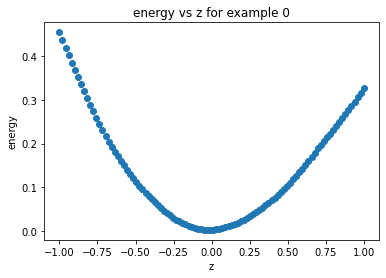

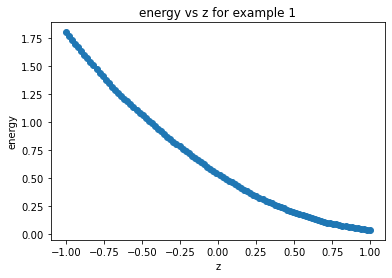

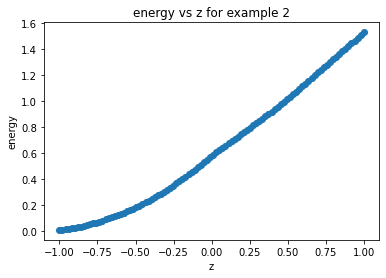

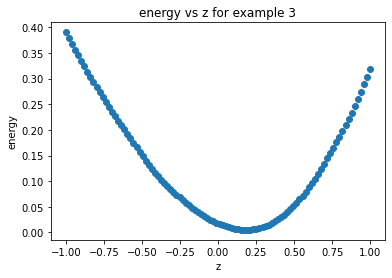

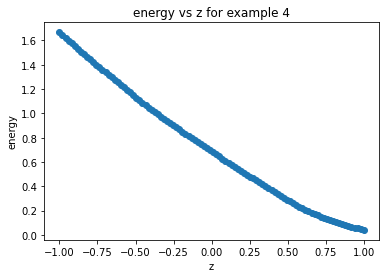

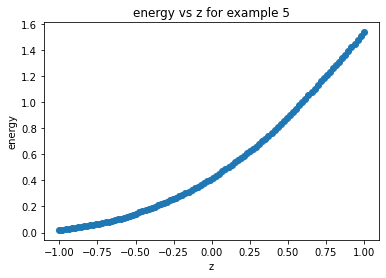

In [249]:
plot_energy(0)
plot_energy(1)
plot_energy(2)
plot_energy(3)
plot_energy(4)
plot_energy(5)